# 01. Perfomance Metrics

by Jose Guillen, Guillermo Figueroa and Samuel Ortiz

## Dependencias

In [355]:
from tabulate import tabulate
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt

# Evaluación de un modelo de clasificación

Contenido del notebook:
1. Introducción
2. Matriz de Confusión
3. Métricas calculadas a partir de una matriz de confusión ( Classification Accuracy & Error, Sensitivity/Recall, Specificity, False Positive Rate, Precision, F1 Score)
4. Curvas ROC y Área Bajo la Curva (AUC)

## Introducción

### Contexto del dataset: "Pima Indians Diabetes Database"

Este conjunto de datos proviene originalmente del Instituto Nacional de Diabetes y Enfermedades Digestivas y del Riñón. El objetivo del conjunto de datos es predecir de manera diagnóstica si un paciente tiene o no diabetes, basándose en ciertas medidas diagnósticas incluidas en el conjunto de datos. Se aplicaron varias restricciones en la selección de estas instancias a partir de una base de datos más grande. En particular, todas las pacientes aquí son mujeres de al menos 21 años de edad y de herencia india Pima.

### Cargamos el dataset y lo visualizamos

In [356]:
# Leyendo el conjunto de datos en un DataFrame de Pandas
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
pima = pd.read_csv("data/diabetes.csv", header=None, names=col_names)
pima.drop(0, inplace=True)
pima.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
1,6,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,183,64,0,0,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0
5,0,137,40,35,168,43.1,2.288,33,1


#### Información de columnas

* pregnant: El número de veces que una mujer ha estado embarazada.
* glucose: La concentración de glucosa en sangre medida en mg/dL.
* bp (blood pressure): La presión arterial sistólica en mm Hg.
* skin: El grosor del pliegue cutáneo del tríceps en mm.
* insulin: La concentración de insulina en sangre en µU/mL.
* bmi (body mass index): El índice de masa corporal, que es una medida de la adiposidad calculada a partir del peso y la altura.
* pedigree: El valor de la función de pedigrí de diabetes, que proporciona información sobre la predisposición genética a la diabetes.
* age: La edad de la paciente en años.
* label: La etiqueta que indica si la paciente tiene diabetes (1) o no (0).

### Predicción del estado de diabetes de un paciente según sus medidas de salud

#### Extraemos características y definimos un modelo de regresión logística

In [357]:
# Se define una lista de características que se utilizarán como entradas para el modelo. 
feature_cols = ['pregnant', 'insulin', 'bmi', 'age']
# Se crea una matriz X que contiene solo las columnas de características seleccionadas del conjunto de datos pima.
X = pima[feature_cols]
# Se crea una serie y que contiene la columna de etiquetas "label" del conjunto de datos pima.
y = pima.label
#Se divide el conjunto de datos en conjuntos de entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Se crea un modelo de regresión logística (logreg).
logreg = LogisticRegression()
# Se entrena el modelo de regresión logística utilizando los datos de entrenamiento
logreg.fit(X_train, y_train)

LogisticRegression()


#### Realizamos predicciones

In [358]:
# Realizar predicciones de clases para el conjunto de prueba.
y_pred_class = logreg.predict(X_test)

##### Comparación entre los valores reales y los valores predichos.


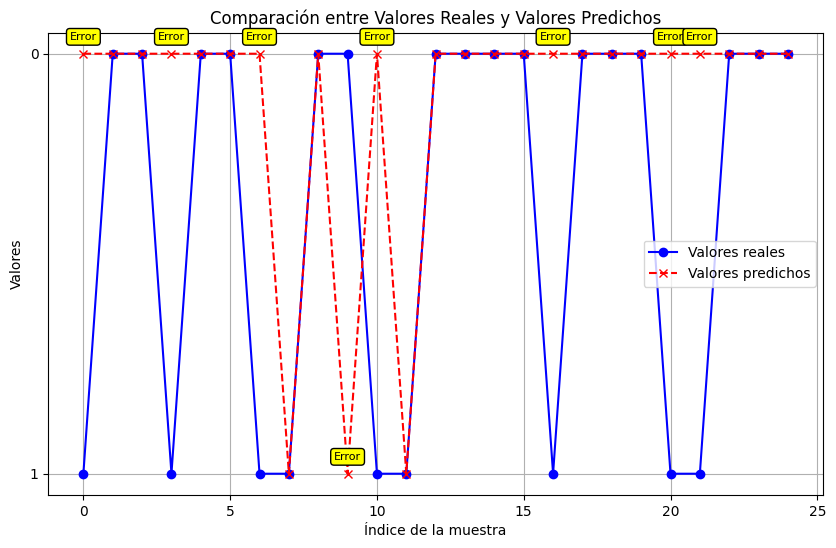

In [359]:
true_values = y_test.values[0:25]
predicted_values = y_pred_class[0:25]

# Mejorando el gráfico con anotaciones mejoradas
plt.figure(figsize=(10, 6))
plt.plot(true_values, label='Valores reales', marker='o', linestyle='-', color='blue')
plt.plot(predicted_values, label='Valores predichos', marker='x', linestyle='--', color='red')
plt.xlabel('Índice de la muestra')
plt.ylabel('Valores')
plt.title('Comparación entre Valores Reales y Valores Predichos')
plt.legend()
plt.grid(True)

# Mejorando las anotaciones
for i, (true, pred) in enumerate(zip(true_values, predicted_values)):
    if true != pred:
        plt.annotate('Error', (i, pred), textcoords="offset points", xytext=(0,10), ha='center',
                     bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=1), fontsize=8)

plt.show()


### Métrica coverage

El término "coverage" puede tener diferentes significados en el contexto del aprendizaje automático y la evaluación de modelos, dependiendo de cómo se aplique. Sin embargo, en el contexto más general y común, "coverage" se refiere a la proporción de casos que un modelo es capaz de hacer predicciones. 

En tareas de clasificación, especialmente con modelos que pueden abstenerse de hacer una predicción, "coverage" podría referirse a la proporción de instancias para las cuales el modelo realiza una predicción.

Dado un conjunto de datos de N instancias, y tu modelo hace predicciones para M de esas instancias. Entonces, el "coverage" se calcularía como:

coverage = M / N

In [378]:
# El número total de instancias en el conjunto de prueba
total_test_instances = X_test.shape[0]

# El número de predicciones hechas por el modelo
# Como la regresión logística hace una predicción para cada instancia, este será igual a total_test_instances
predictions_made = len(y_pred_class)

# Calculando el coverage
coverage = predictions_made / total_test_instances

print("Coverage:", coverage)


Coverage: 1.0


## Matriz de confusion

La matriz de confusión es una herramienta crucial para evaluar el rendimiento de un modelo de clasificación, especialmente en problemas de clasificación binaria. En tu código, la matriz de confusión generada es una matriz de 2x2, lo que indica que estás trabajando con un problema de clasificación binaria.

### Clasificación Binaria

En un problema de clasificación binaria, solo existen dos posibles etiquetas para la salida, generalmente representadas como:

*    Positivo (o '1'): Indica la presencia de una característica o condición específica.
*    Negativo (o '0'): Indica la ausencia de esa característica o condición.

### Componentes de la Matriz de Confusión

La matriz de confusión compara las etiquetas reales con las predicciones hechas por el modelo. Se compone de cuatro elementos esenciales:

*    Verdaderos Positivos (TP): Casos donde el modelo predijo correctamente la clase positiva.
*    Verdaderos Negativos (TN): Casos donde el modelo predijo correctamente la clase negativa.
*    Falsos Positivos (FP): Casos donde el modelo predijo incorrectamente la clase positiva.
*    Falsos Negativos (FN): Casos donde el modelo predijo incorrectamente la clase negativa.

In [360]:
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
confusion

array([[114,  16],
       [ 46,  16]])

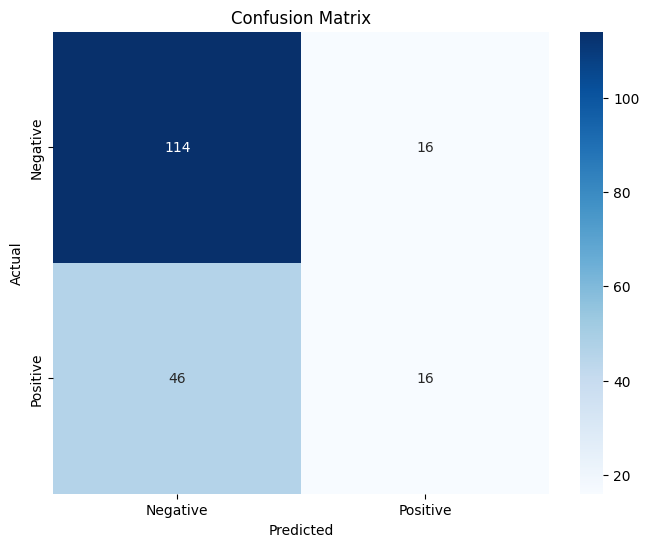

In [361]:
# Crear etiquetas para los ejes
class_names = ['Negative', 'Positive']

# Crear el gráfico de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Añadir títulos y etiquetas
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

# Mostrar el gráfico
plt.show()

Terminología básica dentro del contexto

* True Positives (TP): Predicción correcta de que sí tienen diabetes.
* True Negatives (TN): Predicción correcta de que no tienen diabetes.
* False Positives (FP): Predicción incorrecta de que sí tienen diabetes (un "error de Tipo I").
* Falsos Negativos (FN): Predicción incorrecta de que no tienen diabetes (un "error de Tipo II").

Para cualquier modelo, los errores de tipo 1 y tipo 2 deben ser mínimos y el poder estadístico debe ser alto para respaldar nuestra hipótesis. Analizar estas métricas, como la matriz de confusión, nos da por lo tanto una estimación del rendimiento de nuestro modelo.

## Métricas calculadas a partir de una matriz de confusión

### Accuracy

El accuracy es una métrica de evaluación que mide la precisión de un modelo de clasificación en predecir correctamente quiénes tienen y quiénes no tienen una enfermedad, como la diabetes, en función de ciertas características. Un accuracy del 80% significa que el modelo acierta en aproximadamente el 80% de las predicciones, pero no considera posibles desbalances en las clases o los costos asociados con errores específicos, por lo que en algunos casos pueden ser necesarias métricas adicionales para evaluar mejor el rendimiento del modelo.

Accuracy = (Número de predicciones correctas) / (Número total de predicciones)


In [362]:
# Cálculo de la precisión de clasificación
accuracy = (TP + TN) / float(TP + TN + FP + FN)
data = [["Classification Accuracy", accuracy]]
table = tabulate(data, headers=['Metric', 'Value'], tablefmt='fancy_grid')

print(table)

╒═════════════════════════╤══════════╕
│ Metric                  │    Value │
╞═════════════════════════╪══════════╡
│ Classification Accuracy │ 0.677083 │
╘═════════════════════════╧══════════╛


### Misclassification Rate



La tasa de clasificación errónea es una métrica de evaluación que mide la proporción de predicciones incorrectas hechas por un modelo de clasificación. Es el complemento de la precisión (accuracy) y proporciona una idea de la frecuencia con la que el modelo se equivoca. Esta métrica es particularmente importante en contextos donde los errores de predicción pueden tener consecuencias significativas, como en el diagnóstico de enfermedades.

Missclassification Rate = (Número de predicciones incorrectas) / (Número total de predicciones) 

Missclassification Rate = 1 - Accuracy

In [374]:
missclassification_rate = (FP + FN) / float(TP + TN + FP + FN)
data = [["Classification Error", missclassification_rate]]
table = tabulate(data, headers=['Metric', 'Value'], tablefmt='fancy_grid')

print(table)

╒══════════════════════╤══════════╕
│ Metric               │    Value │
╞══════════════════════╪══════════╡
│ Classification Error │ 0.322917 │
╘══════════════════════╧══════════╛


### Recall/Sensibilidad


El Recall, también conocido como sensibilidad o tasa de verdaderos positivos, es una métrica crucial en la evaluación de modelos de clasificación. Mide la proporción de casos positivos reales que fueron correctamente identificados por el modelo. Es especialmente importante en situaciones donde no detectar los verdaderos positivos (como enfermedades en un contexto médico) es crítico.

Recall = (Número de Verdaderos Positivos) / (Número de Verdaderos Positivos + Número de Falsos Negativos)

In [375]:
recall = TP / float(TP + FN)
data = [["Recall", recall]]
table = tabulate(data, headers=['Metric', 'Value'], tablefmt='fancy_grid')

print(table)

╒══════════╤══════════╕
│ Metric   │    Value │
╞══════════╪══════════╡
│ Recall   │ 0.258065 │
╘══════════╧══════════╛


### Especificidad

La especificidad es una métrica en la evaluación de modelos de clasificación que mide la habilidad del modelo para identificar correctamente los verdaderos negativos. En otras palabras, indica qué tan bien el modelo puede reconocer las situaciones en las que la condición buscada no está presente. Es especialmente útil en contextos donde es crucial no clasificar erróneamente los casos negativos como positivos.

Especificidad = (Número de Verdaderos Negativos) / (Número de Verdaderos Negativos + Número de Falsos Positivos)

In [376]:
specificity = TN / float(TN + FP)
data = [["Specificity", specificity]]
table = tabulate(data, headers=['Metric', 'Value'], tablefmt='fancy_grid')

print(table)

╒═════════════╤══════════╕
│ Metric      │    Value │
╞═════════════╪══════════╡
│ Specificity │ 0.876923 │
╘═════════════╧══════════╛


### Precision

Mide la proporción de predicciones positivas que fueron realmente correctas. La precisión es especialmente relevante en situaciones donde los falsos positivos (predicciones incorrectas de la clase positiva) son de particular preocupación.

Precisión = (Número de Verdaderos Positivos) / (Número de Verdaderos Positivos + Número de Falsos Positivos)

In [366]:
precision = TP / float(TP + FP)
data = [["Precision", precision]]
table = tabulate(data, headers=['Metric', 'Value'], tablefmt='fancy_grid')

print(table)

Precision 0.5


### F1 Score

El F1 Score es una métrica que combina la precisión y el recall en un solo número. Es especialmente útil cuando necesitas equilibrar entre precisión y recall, y es ideal en situaciones donde una alta precisión o un alto recall por sí solos no son suficientes para determinar el rendimiento del modelo.

F1 Score = 2 * (Precisión * Recall) / (Precisión + Recall)

Importancia y Uso

* Equilibrio entre Precisión y Recall: El F1 Score es útil cuando hay una necesidad de equilibrar la precisión con el recall, como en casos donde tanto los falsos positivos como los falsos negativos son costosos.
* Situaciones con Desbalance de Clases: En datasets con un desbalance significativo de clases, el F1 Score ayuda a evaluar el rendimiento del modelo de manera más efectiva que solo usando precisión o recall.
* Aplicaciones Críticas: Se utiliza en situaciones donde es importante no solo identificar correctamente los casos positivos (alto recall) sino también mantener bajo el número de falsos positivos (alta precisión).

Limitaciones

* No Específico para un Tipo de Error: El F1 Score trata los falsos positivos y los falsos negativos de manera igual, lo cual puede no ser adecuado en todas las situaciones.
* Compromiso entre Precisión y Recall: En casos donde uno es mucho más importante que el otro, el F1 Score puede no reflejar adecuadamente la eficacia del modelo para ese propósito específico.

In [377]:
f1_score = (2 * (precision * recall) / (precision + recall))
data = [["F1 Score", f1_score]]
table = tabulate(data, headers=['Metric', 'Value'], tablefmt='fancy_grid')

print(table)

╒══════════╤══════════╕
│ Metric   │    Value │
╞══════════╪══════════╡
│ F1 Score │ 0.340426 │
╘══════════╧══════════╛


### ¿Qué se considera "bueno"?

La evaluación de lo que se considera un "buen" valor para cada una de estas métricas depende en gran medida del contexto específico del problema y del área de aplicación. Sin embargo, puedo proporcionarte algunas pautas generales:

* Precisión: Un valor alto es deseable, especialmente en situaciones donde los falsos positivos son costosos o indeseables. Un valor de precisión de 0.90 o superior suele considerarse bueno, pero esto puede variar según el contexto.

* Recall (Sensibilidad): Un valor alto es crucial en contextos donde es importante capturar todos los casos positivos (como en diagnósticos médicos). Un recall de 0.90 o más es generalmente bueno, aunque en algunas aplicaciones, incluso un valor ligeramente más bajo puede ser aceptable si se equilibra con otras métricas.

* Especificidad: Al igual que con el recall, un valor alto es mejor. En aplicaciones médicas, por ejemplo, una especificidad alta reduce los diagnósticos falsos positivos. Un valor de 0.90 o más se considera generalmente bueno.

* F1 Score: Combina precisión y recall. Un valor alto indica un buen equilibrio entre estas dos métricas. Generalmente, un F1 Score superior a 0.80 es considerado bueno, pero esto puede variar según el problema.

* Accuracy (Exactitud): Mientras más alto mejor, pero en datasets desbalanceados, esta métrica puede ser engañosa. Un valor de 0.90 o superior suele ser bueno, pero siempre debe considerarse en el contexto de la distribución de la clase.

Es importante recordar que estas son solo pautas generales. En la práctica, lo que constituye un valor "bueno" para estas métricas puede variar significativamente dependiendo de la aplicación específica y de los costos relativos asociados con diferentes tipos de errores (falsos positivos vs. falsos negativos). En algunos contextos, sacrificar precisión por recall (o viceversa) puede ser completamente justificable si se alinea con los objetivos y restricciones específicas del problema. Además, siempre es recomendable comparar el rendimiento del modelo con un punto de referencia relevante, como el rendimiento de modelos anteriores o benchmarks de la industria.


## Curvas ROC y Área Bajo la Curva (AUC)


Las curvas ROC son representaciones gráficas que muestran la relación entre la tasa de verdaderos positivos y la tasa de falsos positivos de un modelo de clasificación. Estas tasas se calculan a diferentes umbrales de decisión, lo que permite evaluar cómo el cambio en el umbral afecta al rendimiento del modelo.

Importancia de los Umbrales:

*    Elección del Umbral: La curva ROC es útil para seleccionar un valor de umbral que equilibre entre sensibilidad y especificidad, lo cual es crítico en escenarios comerciales o clínicos donde los costos de falsos positivos y falsos negativos pueden variar considerablemente.
*    Visualización de Trade-offs: Proporciona una forma clara de visualizar el trade-off entre capturar verdaderos positivos y evitar falsos positivos.

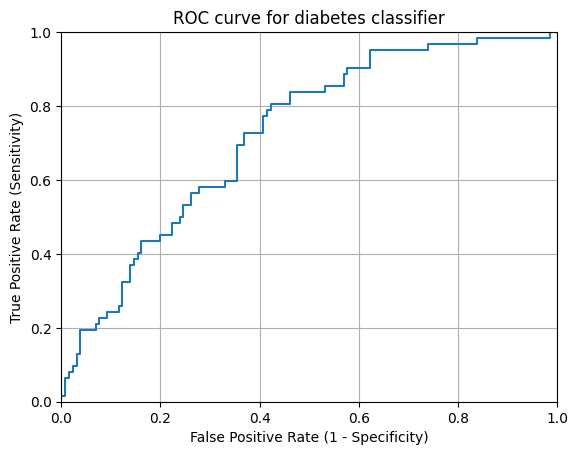

In [368]:
y_test = y_test.astype(int)

# Predecir probabilidades de la clase de personas con diabetes para el conjunto de prueba
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
# Calcular la tasa de falsos positivos (fpr), la tasa de verdaderos positivos (tpr) y los umbrales para la curva ROC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)



In [369]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [383]:
evaluate_threshold(0.5)

Sensitivity: 0.25806451612903225
Specificity: 0.8769230769230769


In [371]:
evaluate_threshold(0.8)

Sensitivity: 0.016129032258064516
Specificity: 0.9923076923076923


El AUC es una métrica que mide la calidad del modelo de clasificación, representando el porcentaje del gráfico ROC que se encuentra debajo de la curva trazada.

Relevancia del AUC

* Evaluación del Rendimiento: Un AUC alto indica que el modelo tiene una buena medida de separabilidad; es decir, tiene una mayor capacidad para distinguir entre clases.
* Útil en Desbalance de Clases: El AUC es particularmente valioso en datasets con un alto desequilibrio de clases, ya que no se ve tan afectado por la proporción de clases como otras métricas.
* Comparación de Modelos: Permite comparar la eficacia de diferentes clasificadores, siendo una métrica integral para evaluar modelos en competencias o benchmarks.

In [372]:
# IMPORTANTE: El primer argumento son los valores verdaderos, el segundo argumento son las probabilidades predichas
print("AUC Score:",metrics.roc_auc_score(y_test, y_pred_prob))

AUC Score: 0.7227047146401985


La validación cruzada aplicada al cálculo del AUC proporciona una estimación más robusta y menos sesgada del rendimiento del modelo, ya que evalúa cómo el modelo se generaliza a diferentes muestras del dataset.

In [373]:
# calculate cross-validated AUC
print("Cross-Validated AUC Score:",cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean())

Cross-Validated AUC Score: 0.7425071225071225


* logreg: Este es el modelo que estás evaluando, en este caso, una instancia de LogisticRegression. Es el objeto que ya ha sido creado y que contiene la configuración del modelo que se entrenará y se validará a través de la validación cruzada.

* X: Representa la matriz de características del conjunto de datos que se utiliza para entrenar el modelo. Son los datos de entrada que el modelo usará para aprender.

* y: Son las etiquetas verdaderas asociadas con las entradas X. En un contexto de clasificación, y contiene la clase o categoría para cada observación en X.

* cv=10: Este parámetro define el número de pliegues que se utilizarán en la validación cruzada. Un cv de 10 significa que los datos se dividirán en 10 partes: el modelo se entrena en 9 y se prueba en 1, y este proceso se repite 10 veces, de manera que cada parte de los datos se utiliza una vez como conjunto de prueba.

* scoring='roc_auc': Indica la métrica que se utilizará para evaluar el modelo en cada pliegue de la validación cruzada. En este caso, se usa el área bajo la curva (AUC) de la curva de característica operativa del receptor (ROC), que es una métrica comprensiva de la capacidad del modelo para distinguir entre las clases positivas y negativas a varios umbrales de decisión.